In [8]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Getting the closest embedded charts

In [10]:
clip = pd.read_csv('embeddings/image_clip_embeddings.csv')
import ast  # ast.literal_eval safely evaluates a string containing a Python literal expression
clip['embeddings'] = clip['Embeddings'].apply(ast.literal_eval)
clip = clip.drop(columns=['Embeddings'])
clip['image'] = clip['Filename'].apply(lambda x: 'screenshots/' + x)
clip.head()

,Filename,embeddings,image
0,heatmap_sw_1_2_s_1_0.png,"[-0.29299911856651306, -0.24236251413822174, -...",screenshots/heatmap_sw_1_2_s_1_0.png
1,two_by_two_p_4_m_10_sw_0_7_s_1_2.png,"[-0.024562444537878036, -0.5847567319869995, 0...",screenshots/two_by_two_p_4_m_10_sw_0_7_s_1_2.png
2,multiple_view_p_2_m_12_sw_0_7_s_0_7.png,"[0.05260123312473297, -0.2164071798324585, 0.3...",screenshots/multiple_view_p_2_m_12_sw_0_7_s_0_...
3,two_by_two_uneven_w_m_20_sw_0_7_s_0_7.png,"[0.25502264499664307, -0.36298295855522156, 0....",screenshots/two_by_two_uneven_w_m_20_sw_0_7_s_...
4,multiple_view_p_1_m_8_sw_1_2_s_1_0.png,"[0.0062620267271995544, 0.049051493406295776, ...",screenshots/multiple_view_p_1_m_8_sw_1_2_s_1_0...


In [4]:
# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [23]:
query_image = Image.open('hic-matrix.png')

# Process the image for the CLIP model
inputs = processor(images=query_image, return_tensors="pt", padding=True)

# Generate embeddings
with torch.no_grad():
    query_embedding = model.get_image_features(**inputs).numpy().flatten()

The 5 most similar images using CLIP are the following:


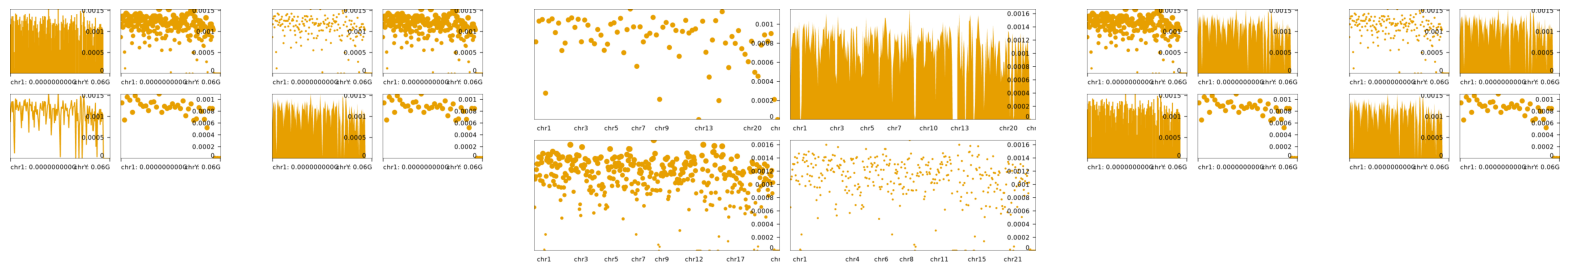

In [24]:

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def most_similar(embedding, embeddings, top_n=5):
    similarities = np.array([cosine_similarity(embedding, emb) for emb in embeddings])
    return np.argsort(similarities)[::-1][:top_n]

def display_images(img_paths):
    # concatenate images horizontally and display
    images = [Image.open(img_path) for img_path in img_paths]
    padding = 100
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths) + padding * (len(images) - 1)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    # Make the background white
    new_im.paste((255, 255, 255), (0, 0, total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0] + padding
    # open image with matplotlib
    plt.figure(figsize=(20, 20))
    plt.imshow(new_im)
    plt.axis('off')

clip_embeddings = np.array(clip['embeddings'].to_list())
top_5 = most_similar(query_embedding, clip_embeddings, top_n=5)
img_paths = clip.loc[top_5]['image'].to_list()
print('The 5 most similar images using CLIP are the following:')
display_images(img_paths)
